# 机器学习纳米学位
猫狗大战毕业项目   
张斌   
 
2019年1月31日
 

## I. 问题的定义

### 项目概述

本项目为kaggle竞赛项目，目的是训练⼀个机器学习模型， 输入⼀张图片来分辨图像中是猫还是狗。是⼀个典型的计算机视觉问题中的图像⼆分类问题。本项目使用的卷积神经网络CNN，卷积神经网络是深度学习技术中极具代表的网络结构之⼀，在图像处理领域取得了很大。CNN 相较于传统的图像处理算法的优点之⼀在于，避免了对图像复杂的前期预处理过程，可以直接输入原始图像。通过利用kaggle提供的输入数据中的训练集和测试集中的图片，利用CNN网络对图片进行多次卷基层和池化层处理，在输出层进⾏softmax 计算得到两个类别各自的概率，通过规范的学习，训练出最终的模型。   
本项目最终需要训练基于 CNN 的机器学习模型，对测试样本进⾏分类，识别测试集中的图片中包含猫狗的概率。

### 问题陈述
从kaggle处下载的数据中包含的图片包含训练集和测试集，这次主要解决的问题就是通过计算机图像识别技术，本次采用CNN的方式通过训练集训练出模型，对测试集中的图片中是猫或是狗的概率进行预测，并将结果存入sample_submission.csv文件中。   
1、首先我将对数据集中的图片进行筛选，剔除异常的图片。   
2、利用训练集中的图片进行训练，但是神经网络输入点图像的维度和像素是固定的，所以需要将图像的大小在输入钱进行统一。    
3、建立CNN的数据模型。    
4、对CNN模型进行训练，得到最优的模型。   
5、利用模型预测测试集中的图片包含猫狗的概率。
我期望的结果是我训练出的模型可以准确的识别出图片中包含的是猫还是狗。

### 评价指标
kaggle的评估标准是log损失函数，以下为表达式：   
$LogLoss = -\frac{1}{n}\sum_{i=1}^n [y_ilog(\hat{y}_i)+(1-y_i)log(1- \hat{y}_i)]$

其中：   
n 是测试集中图片数量。   
$\hat{y}_i$是图片预测为狗的概率。   
${y}_i$如果图像是狗，则为1，如果是猫，则为0。   
$log()$是自然对数。   
对数损失越小，代表模型的性能越好。    
我使用的评估指标是kaggle提出了，首先保证的评估指标的适用性，同时损失函数在分类问题中的评估效果也是在许多分类项目中等到高度评价的。

## II. 分析

### 数据的探索
此数据集从kaggle上下载。Dogs vs. Cats Redux: Kernels Edition   
全部解压后包括：train、test、sample_submission.csv。   
train文件夹中包含25000 张猫狗的图片，每张图片的名字为“类型+序号.jpg”，此文件夹为训练集，用这些图片对算法进行训练，根据图片的名称可以定义图片的类型，根据图片本身和标志类型，训练模型，如下图：   
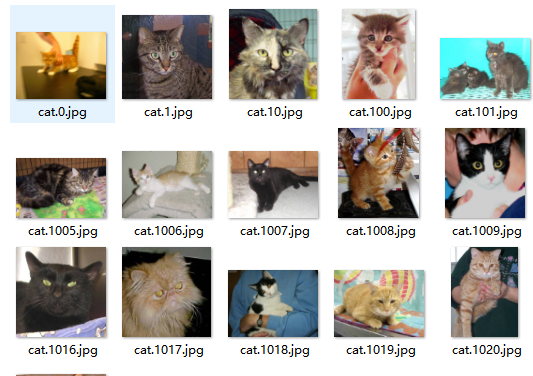

test文件夹中包含12500张猫狗的图片，每张图片的名字为“序号.jpg”，此文件夹为测试集，用这些图片对算法进行测试。通过训练得到的模型预测图片猫狗的概率。      
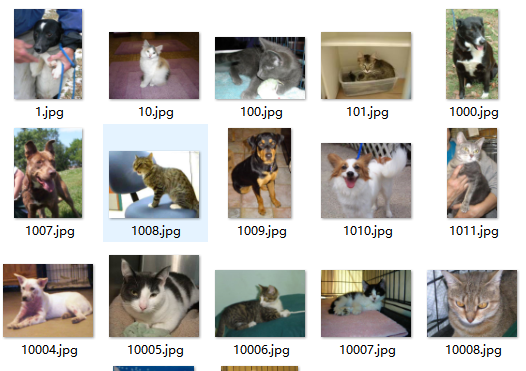
sample_submission.csv文件内需要将算法模型预测的测试集中图片是猫或是狗的百分比和图片序号一一对应填入，并上传至kaggle打分。   

在以上的数据中，应该关注训练集和测试集中异常的图片，主要包括分辨率过低，图片大小太小，图片内容不属于猫或狗。以下通过分析剔除异常图片，对利用可视化的手段发现异常图片。

### 探索性可视化
在这一部分，你需要对数据的特征或特性进行概括性或提取性的可视化。这个可视化的过程应该要适应你所使用的数据。就你为何使用这个形式的可视化，以及这个可视化过程为什么是有意义的，进行一定的讨论。你需要考虑的问题：
- _你是否对数据中与问题有关的特性进行了可视化？_
- _你对可视化结果进行详尽的分析和讨论了吗？_
- _绘图的坐标轴，标题，基准面是不是清晰定义了？_

### 算法和技术
在给定⼀张图⽚，系统需要预测出图像属于预先定义类别中的哪⼀类。在计算机视觉领域，⽬前解决这类问题的核⼼技术框架是深度学习（Deep Learning），特别地，针对图像类型的数据，是深度学习中的卷积神经⽹络（Convolutional Neural Networks, ConvNets）架构。常⻅的卷积神经⽹络架构如下：

读取图片   
↓   
{{卷积-ReLU}*若干次→池化}*若干次   
↓   
全连接*若干次   
↓   
输出结果

卷积神经⽹络中卷积层和池化层主要是对图⽚的⼏何特征进⾏抽取，⽐如浅层的卷积池化层可以抽取出⼀些直线，
⻆点等简单的抽象信息，深层的卷积池化层可以抽取⼈脸等复杂的抽象信息，最后的全连接层才是对图⽚分类的关
键处理。
因此可以利⽤已经训练好的卷积神经⽹络提取图⽚中复杂的⼏何特征，即将原始图⽚⽤已经训练好的卷积神经⽹络
处理之后的输出，作为新的输⼊，然后加上⾃⼰的全连接层，去进⾏分类。在模型训练的过程中，只改变新加的全
连接层的权重。
总的来说，卷积神经⽹络是⼀种特殊的神经⽹络结构，即通过卷积操作可以实现对图像特征的⾃动学习，选取那些
有⽤的视觉特征以最⼤化图像分类的准确率。

![title](img/demo1.png)

上图给出了⼀个简单的猫狗识别的卷积神经⽹络结构，在最底下（同时也是最⼤的）的点块表⽰的是⽹络的输⼊层，通常这⼀层作⽤是读⼊图像作为⽹络的数据输⼊。在最上⾯的点块是⽹络的输出层，其作⽤是预测并输出读⼊图像的类别，在这⾥由于只需要区分猫和狗，因此输出层只有 2 个神经计算单元。⽽位于输⼊和输出层的，都称之为隐含层，图中有 3 个隐含层，图像分类的隐含层都是由卷积操作完成的，因此这样的隐含层也成为卷积层。因此，输⼊层、卷积层、输出层的结构及其对应的参数就构成了⼀个典型的卷积神经⽹络。在实际中使⽤的卷积神经⽹络要⽐这个⽰例的结构更加复杂，

由于每⼀种神经⽹络提取的特征都不⼀样，因此本项⽬将多个神经⽹络处理的结果拼接，作为最后⼀层全连接层的输⼊，这样做可以有效地降低⽅差。
本项⽬迁移学习部分使⽤ Keras 实现，⽽ Keras 中可以导⼊的模型有 Xception，VGG16，VGG19，ResNet，InceptionV3等。 综合考虑模型的分类准确率和⼤⼩，选⽤迁移学习的基础模型为ResNet,Xception,InceptionV3。

**ResNet：**   
ResNet引⼊了残差⽹络结构，通过这种残差⽹络结构，可以把⽹络层弄的很深，并且最终的分类效果也⾮常好。   
在此之前，深度神经⽹络常常会有梯度消失问题的困扰，即来⾃误差函数的梯度信号会在反向传播回更早的层时指数级地下降。本质上讲，在误差信号反向回到更早的层时，它们会变得⾮常⼩以⾄于⽹络⽆法学习。但是，因为ResNet 的梯度信号可以直接通过捷径连接回到更早的层，所以⼀下⼦就可以构建 50 层、101 层、152 层甚⾄1000 层以上的⽹络了，⽽且它们的表现依然良好。

**Xception：**   
Xception 实际上采⽤了类似于 ResNet 的⽹络结构，主体部分采⽤了模块化设计。   
Xception 是 google 继 Inception 后提出的对 Inception v3 的另⼀种改进，主要是采⽤ depthwise separable convolution 来替换原来Inception v3中的卷积操作。

**Inception V3：**   
inception V3把googlenet里一些7*7的卷积变成了1*7和7*1的两层串联，3*3的也一样，变成了1*3和3*1，这样加速了计算，还增加了网络的非线性，减小过拟合的概率。另外，网络的输入从224改成了299.

### 基准模型
本项目将采用ResNet,Xception,VGGNet这三个模型。   
本项目的最低要求是kaggle Public Leaderboard前10%。   
在kaggle上，总共有1314只队伍参加了比赛，前10%为131位之前，131位的得分是0.06127，所以模型预测结果分数要小于0.06127。

## III. 方法

### 数据预处理
对于异常数据的清理采⽤ 优达学习笔记 提供的“预处理模型”⽅法实现异常数据清洗。   
评价 ImageNet 有指标 Top-1 和 Top-5：

![title](img/demo2.png)

本项⽬使⽤ InceptionV3 top-10 训练train训练集。训练过程中将图⽚的名称和预测 top-10 的结果保存到字典⾥，训练结束后保存字典为train_decode_predictions.csv 。将模型预测结果与 ImageNetClasses.csv 进⾏异常数据排查。具体实现代码参考 outlier_detection.ipynb 。

使⽤ InceptionV3 模型排查出的异常图⽚总数为：131张，其中有些图⽚是正常的，经过筛选后选出 43 张异常图⽚作为本试验要清理的异常图⽚。   
数据集清洗后，猫的数量：12482，狗的数量：12475，测试集图⽚数量：12500。   
由于我们的数据集的⽂件名是以 type.num.jpg 这样的⽅式命名的，⽐如 cat.0.jpg，但是使⽤ Keras 的ImageDataGenerator 需要将不同种类的图⽚分在不同的⽂件夹中，因此我们需要对数据集进⾏预处理。   

### 执行过程
#### ⽣成迁移学习特征向量####
Xception，InceptionV3 和 ResNet50 这三个模型对于输⼊数据都有各⾃的默认值，⽐如在输⼊图⽚⼤⼩维度上，Xception 和 InceptionV3 默认输⼊图⽚⼤⼩是299*299 ，ResNet50 默认输⼊图⽚⼤⼩是224*224 ；在输⼊数值维度上，Xception 和 InceptionV3 默认输⼊数值在 (-1, 1) 范围内。当要输⼊与默认图⽚⼤⼩不同的图⽚时，只需传⼊当前图⽚⼤⼩即可。ResNet50 需要对图⽚进⾏中⼼化处理，由于载⼊的 ResNet50 模型是在 ImageNet 数据上训练出来的，所以在预处理中每个像素点都要减去 ImageNet 均值。当要输⼊与默认图⽚⼤⼩不同的图⽚时，只需传⼊当前图⽚⼤⼩即可。当输⼊数值不符合默认要求时，使⽤每个模型的预处理函数 preprocess_input 即可将输⼊图⽚处理成该模型的标准输⼊。   
常⻅的卷积神经⽹络结构在前⾯的若⼲层都是卷积池化层及其各种变种，后⾯⼏层都是全连接层，这些全连接层之前的⽹络层被称为瓶颈层 (bottleneck). 将新的图⽚通过训练好的卷积神经⽹络直到瓶颈层的过程可以看做是对图像进⾏特征提取的过程。 。⼀般情况下，为了减少内存的消耗， 加快计算的过程，再将瓶颈层的结果输⼊全连接层之前，做⼀次全局平均池化。这么做还有⼀个好处，那就是可以降低过拟合的程度。

### 完善
本项⽬通过对图⽚中的⾊彩-像素⽐进⾏ IQR 分析，经⼈⼯筛选后剔除了分辨率低、⽆关的图⽚，这种⽅法并不能把所有的异常图⽚都剔除掉。⽐如还有⼀些图⽚被别的物体遮挡，对训练造成⼲扰等等。后期可以考虑多⽅⾯对图⽚做筛选处理。    
对模型参数的优化，通过不同的优化器的尝试得到更好的优化结果。    

## IV. 结果
_（大概 2-3 页）_

### 模型的评价与验证
还没有结果。


### 合理性分析
在这个部分，你需要利用一些统计分析，把你的最终模型得到的结果与你的前面设定的基准模型进行对比。你也分析你的最终模型和结果是否确确实实解决了你在这个项目里设定的问题。你需要考虑：
- _最终结果对比你的基准模型表现得更好还是有所逊色？_
- _你是否详尽地分析和讨论了最终结果？_
- _最终结果是不是确确实实解决了问题？_

## V. 项目结论
_（大概 1-2 页）_

### 结果可视化
在这一部分，你需要用可视化的方式展示项目中需要强调的重要技术特性。至于什么形式，你可以自由把握，但需要表达出一个关于这个项目重要的结论和特点，并对此作出讨论。一些需要考虑的：
- _你是否对一个与问题，数据集，输入数据，或结果相关的，重要的技术特性进行了可视化？_
- _可视化结果是否详尽的分析讨论了？_
- _绘图的坐标轴，标题，基准面是不是清晰定义了？_

### 对项目的思考
在这一部分，你需要从头到尾总结一下整个问题的解决方案，讨论其中你认为有趣或困难的地方。从整体来反思一下整个项目，确保自己对整个流程是明确掌握的。需要考虑：
- _你是否详尽总结了项目的整个流程？_
- _项目里有哪些比较有意思的地方？_
- _项目里有哪些比较困难的地方？_
- _最终模型和结果是否符合你对这个问题的期望？它可以在通用的场景下解决这些类型的问题吗？_


### 需要作出的改进
在这一部分，你需要讨论你可以怎么样去完善你执行流程中的某一方面。例如考虑一下你的操作的方法是否可以进一步推广，泛化，有没有需要作出变更的地方。你并不需要确实作出这些改进，不过你应能够讨论这些改进可能对结果的影响，并与现有结果进行比较。一些需要考虑的问题：
- _是否可以有算法和技术层面的进一步的完善？_
- _是否有一些你了解到，但是你还没能够实践的算法和技术？_
- _如果将你最终模型作为新的基准，你认为还能有更好的解决方案吗？_